## Setup

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from datetime import datetime

import numpy as np
import pandas as pd
import random
import tensorflow as tf
import isuelogit as isl
import glob
import time

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/pesuelogit


In [3]:
# Internal modules
from src.pesuelogit.models import UtilityParameters, BPRParameters, ODParameters, PESUELOGIT
from src.pesuelogit.visualizations import plot_predictive_performance, plot_convergence_estimates, plot_top_od_flows_periods, plot_utility_parameters_periods, plot_rr_by_period, plot_rr_by_period_models, plot_total_trips_models
from src.pesuelogit.networks import load_k_shortest_paths, read_paths, build_fresno_network, \
    Equilibrator, sparsify_OD, ColumnGenerator, read_OD
from src.pesuelogit.etl import data_curation, add_period_id, get_tensors_by_year
from src.pesuelogit.descriptive_statistics import nrmse, mape, mse

In [4]:
# Seed for reproducibility
_SEED = 2023
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

In [5]:
# To report global runtime
t0_global = time.time()

## Build Fresno network

In [6]:
fresno_network = build_fresno_network()

## Read OD matrix

In [7]:
read_OD(network=fresno_network, sparse=True)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs



## Read paths

In [8]:
#read_paths(network=fresno_network, update_incidence_matrices=True, filename='paths-fresno.csv')
read_paths(network=fresno_network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')

# For quick testing
# Q = fresno_network.load_OD(sparsify_OD(fresno_network.Q, prop_od_pairs=0.99))
# load_k_shortest_paths(network=fresno_network, k=2, update_incidence_matrices=True)

18289 paths were read in 6.8[s]              

18289 paths were loaded in the network

Updating incidence matrices

Matrix D (2413, 18289) generated in 6.6[s]               

Matrix M (6970, 18289) generated in 2.5[s]               

Matrix C (18289, 18289) generated in 0.9[s]               




## Read spatiotemporal data

In [9]:
folderpath = isl.config.dirs['read_network_data'] + 'links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# Select data from Tuesday to Thursday
df = df[df['date'].dt.dayofweek.between(1, 3)]
# Select data from Tuesdays only
# df = df[df['date'].dt.dayofweek.between(1,1)]
# df = df[df['date'].dt.year == 2019]

In [10]:
# Add period id for timevarying estimation

period_feature = 'hour'

df['period'] = df['date'].astype(str) + '-' + df[period_feature].astype(str)
# df['period'] = df.period.map(hash)

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


## Data curation

In [11]:
df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

tt_sd_adj = df.groupby(['period_id','link_key'])[['tt_avg']].std().reset_index().rename(columns = {'tt_avg': 'tt_sd_adj'})

df = df.merge(tt_sd_adj, on = ['period_id','link_key'])

df = data_curation(df)

df['tt_sd'] = df['tt_sd_adj']

In [12]:
# Units of travel time features are converted from hours to minutes
df['tt_sd'] = df['tt_sd']*60
df['tt_avg'] = df['tt_avg']*60
df['tt_ff'] = df['tt_ff']*60

## Utility function

In [13]:
features_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']
# features_Z = ['speed_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']


utility_parameters = UtilityParameters(features_Y=['tt'],
                                       features_Z=features_Z,
                                       initial_values={'tt': 0, 'c': 0, 's': 0, 'psc_factor': 0,
                                                       'fixed_effect': np.zeros_like(fresno_network.links)},
                                       signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                              'bus_stops': '-', 'intersections': '-'},
                                       trainables={'psc_factor': False, 'fixed_effect': False},
                                       )

utility_parameters.constant_initializer(0)

## Data processing

In [14]:
n_links = len(fresno_network.links)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
X, Y = {}, {}

In [15]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in fresno_network.links:
    fresno_network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==str(link.key)])

## Training set

In [16]:
# Data between 4pm and 5pm to estimate LUE, ODLUE and ODLULPE models
X, Y = get_tensors_by_year(df[df.hour.isin([16])], features_Z = features_Z, network = fresno_network)
#XT, YT = get_tensors_by_year(df[df.hour.isin([6,7,8, 15,16,17])], features_Z = features_Z, network = fresno_network)

# Split in training and test sets
X_train, X_test, Y_train, Y_test = X[2019], X[2020], Y[2019], Y[2020]
# XT_train, XT_test, YT_train, YT_test = XT[2019], XT[2020], YT[2019], YT[2020]
X_test, Y_test = None, None
XT_test, YT_test = None, None

## Configuration

In [17]:
# For testing
#_EPOCHS = {'learning': 2, 'equilibrium': 1}
#_EPOCHS = {'learning': 10, 'equilibrium': 0}
_EPOCHS = {'learning': 300, 'equilibrium': 0}
# _BATCH_SIZE = 16
_BATCH_SIZE = None
_LR = 5e-1

# We set 0 relative gap so the algorithm finishes until completing iterations
_RELATIVE_GAP = 0 #1e-10
_XTICKS_SPACING = 50
_EPOCHS_PRINT_INTERVAL = 50

_FIXED_EFFECT = False

_LOSS_WEIGHTS ={'od': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1, 'ntrips': 0, 'prop_od': 0}
_LOSS_METRIC  = nrmse
_MOMENTUM_EQUILIBRIUM = 1

# Including historic OD matrix
# _LOSS_WEIGHTS ={'od': 1, 'tt': 1, 'flow': 1, 'eq_flow': 1}
# _MOMENTUM_EQUILIBRIUM = 0.99

# _LOSS_METRIC = mse
# _LOSS_WEIGHTS ={'od': 1, 'theta': 0, 'tt': 1e10, 'flow': 1, 'eq_flow': 1}

print(f"_LOSS_WEIGHTS: {_LOSS_WEIGHTS}, _MOMENTUM_EQUILIBRIUM: {_MOMENTUM_EQUILIBRIUM}, "
      f"epochs: { _EPOCHS}, 'LR: {_LR}")

_LOSS_WEIGHTS: {'od': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1, 'ntrips': 0, 'prop_od': 0}, _MOMENTUM_EQUILIBRIUM: 1, epochs: {'learning': 300, 'equilibrium': 0}, 'LR: 0.5


### Sensitivity equilibrium weight

In [18]:
lambdas_eq =  np.linspace(1e-1,10,num = 20)
#lambdas_eq =  np.logspace(-3,1,num = 20)
#lambdas_eq = np.logspace(0.1,2,num = 20)
#lambdas_eq =  np.linspace(1e-1,10,num = 4)
print(lambdas_eq)

[ 0.1     0.6211  1.1421  1.6632  2.1842  2.7053  3.2263  3.7474  4.2684
  4.7895  5.3105  5.8316  6.3526  6.8737  7.3947  7.9158  8.4368  8.9579
  9.4789 10.    ]


In [19]:
losses_eq = []
losses_flow = []
losses_tt = []
relative_gaps = []

for lambda_eq in lambdas_eq:

    _LOSS_WEIGHTS ={'od': 0, 'tt': 1, 'flow': 1, 'eq_flow': lambda_eq, 'ntrips': 0, 'prop_od': 0}

    _FIXED_EFFECT = False

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                                   'beta': 4*np.ones_like(fresno_network.links,dtype = np.float32),
                                                   # 'beta': 4
                                                   },
                                   trainables={'alpha': True, 'beta': True},
                                   # trainables={'alpha': True, 'beta': False},
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={10: fresno_network.q.flatten()},
                                 # total_trips={10: 1e5},
                                 trainable=True
                                 )

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'tt_sd': '-',
                                                  'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'
                                                  },
                                           trainables={'psc_factor': False, 'fixed_effect': _FIXED_EFFECT,
                                                       'tt': True, 'tt_sd': True,
                                                       'median_inc': True, 'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           time_varying = True
                                           )

    equilibrator = Equilibrator(
        network=fresno_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )


    odlulpe = PESUELOGIT(
    key='odlulpe',
    network=fresno_network,
    dtype=tf.float64,
    equilibrator=equilibrator,
    utility=utility_parameters,
    bpr=bpr_parameters,
    od=od_parameters,
    n_periods = len(np.unique(X_train[:,:,-1].numpy().flatten()))
    )

    train_results_dfs, test_results_dfs = odlulpe.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_weights=_LOSS_WEIGHTS,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        loss_metric=_LOSS_METRIC,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = odlulpe.split_results(results=train_results_dfs)

    losses_flow.append(mse(actual=odlulpe.observed_flows, predicted = odlulpe.predicted_flow()).numpy())
    losses_tt.append(mse(actual=odlulpe.observed_traveltimes, predicted = odlulpe.predicted_traveltime()).numpy())
    losses_eq.append(mse(actual=odlulpe.flows(), predicted=odlulpe.compute_link_flows(X_train)).numpy())

    relative_gaps.append(train_results_losses['relative_gap'].iloc[-1])

    # Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
    theta_df = plot_utility_parameters_periods(odlulpe, period_keys = period_keys, period_feature='hour', plot = False)

    # sns.displot(pd.DataFrame({'fixed_effect':np.array(odlulpe.fixed_effect)}),
    #             x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    #print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe.theta.numpy())))}")
    print(f"\nMSE link flows={losses_flow[-1]:0.2g}, "
          f"MSE travel times={losses_tt[-1]:0.2g}, "
          f"MSE equilibriun loss={losses_eq[-1]:0.2g}\n")

hyperparameters loss function: {'od': 0, 'tt': 1, 'flow': 1, 'eq_flow': 0.1, 'ntrips': 0, 'prop_od': 0}

Epoch: 0/300, n_periods: 1,  n_timepoints: 15, coverage t, x: [0.87 0.06]
0: train_loss=1.8e+06, val_loss=0, train_loss tt=0.11, val_loss tt=0, train_loss flow=1.8e+06, val_loss flow=0, theta = [0. 0. 0. 0. 0. 0.], avg rr = nan, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=2.5e-29, loss ntrips=0, total trips=[6.6e+04], lambda eq=0.1, relative x=2.2e-16, relative gap=0, train flow equilibrium loss=1.7e-25, time: 2.6

Epoch: 1/300, n_periods: 1,  n_timepoints: 15, coverage t, x: [0.87 0.06]
1: train_loss=8.1e+05, val_loss=0, train_loss tt=0.012, val_loss tt=0, train_loss flow=1.7e+06, val_loss flow=0, theta = [-0.5   -0.474  0.    -0.499  0.    -0.5  ], avg rr = 0.95, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=3.7, loss prop od=1.3, loss ntrips=0, total trips=[6.5e+04], lambda eq=0.048, relative x=0.19, relative gap

In [20]:
hyperparameter_search_eq = pd.DataFrame({'lambdas_eq': lambdas_eq,
                                      'loss_tt': losses_tt,
                                      'loss_flow': losses_flow,
                                      'loss_eq': losses_eq,
                                      'relative_gaps': relative_gaps
                                      })
hyperparameter_search_eq

,lambdas_eq,loss_tt,loss_flow,loss_eq,relative_gaps
0,0.100000,0.001213,20840.879671,21942.437164,0.025669
1,0.621053,0.001186,21313.928311,18995.088915,0.021668
2,1.142105,0.001187,22569.197811,17541.392444,0.020205
3,1.663158,0.001187,24899.901326,16141.087107,0.019388
4,2.184211,0.001188,28973.210041,14655.073547,0.018983
5,2.705263,0.001188,36461.937504,12743.239983,0.018484
6,3.226316,0.001192,53313.603437,9941.935777,0.016228
7,3.747368,0.001192,116576.686196,4689.560040,0.015883
8,4.268421,0.001259,289924.312379,397.458515,0.009171
9,4.789474,0.001201,336684.057717,100.737435,0.004414


### Sensitivity travel time parameter


In [22]:

# Grid of values for hyperparameter associated to travel time and equilibrium in the loss function
lambdas_tt = np.linspace(1e-1, 10, num=20)
#lambdas_tt =  np.logspace(-2,1,num = 20)
lambdas_tt

array([ 0.1   ,  0.6211,  1.1421,  1.6632,  2.1842,  2.7053,  3.2263,
        3.7474,  4.2684,  4.7895,  5.3105,  5.8316,  6.3526,  6.8737,
        7.3947,  7.9158,  8.4368,  8.9579,  9.4789, 10.    ])

In [23]:
losses_eq = []
losses_flow = []
losses_tt = []
relative_gaps = []

for lambda_tt in lambdas_tt:
    _LOSS_WEIGHTS = {'od': 0, 'tt': lambda_tt, 'flow': 1, 'eq_flow': 1, 'ntrips': 0, 'prop_od': 0}

    _FIXED_EFFECT = False

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15 * np.ones_like(fresno_network.links, dtype=np.float32),
                                                   'beta': 4 * np.ones_like(fresno_network.links, dtype=np.float32),
                                                   },
                                   trainables={'alpha': True, 'beta': True},
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={10: fresno_network.q.flatten()},
                                 trainable=True
                                 )

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'tt_sd': '-',
                                                  'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'
                                                  },
                                           trainables={'psc_factor': False, 'fixed_effect': _FIXED_EFFECT,
                                                       'tt': True, 'tt_sd': True,
                                                       'median_inc': True, 'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           time_varying=True
                                           )

    equilibrator = Equilibrator(
        network=fresno_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    odlulpe = PESUELOGIT(
        key='odlulpe',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
        n_periods=len(np.unique(X_train[:, :, -1].numpy().flatten()))
    )

    train_results_dfs, test_results_dfs = odlulpe.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_weights=_LOSS_WEIGHTS,
        momentum_equilibrium=_MOMENTUM_EQUILIBRIUM,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        loss_metric=_LOSS_METRIC,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = odlulpe.split_results(results=train_results_dfs)

    losses_flow.append(mse(actual=odlulpe.observed_flows, predicted=odlulpe.predicted_flow()).numpy())
    losses_tt.append(mse(actual=odlulpe.observed_traveltimes, predicted=odlulpe.predicted_traveltime()).numpy())
    losses_eq.append(mse(actual=odlulpe.flows(), predicted=odlulpe.compute_link_flows(X_train)).numpy())

    relative_gaps.append(train_results_losses['relative_gap'].iloc[-1])

    # Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
    theta_df = plot_utility_parameters_periods(odlulpe, period_keys=period_keys, period_feature='hour', plot=False)

    # sns.displot(pd.DataFrame({'fixed_effect':np.array(odlulpe.fixed_effect)}),
    #             x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    #print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe.theta.numpy())))}")
    print(f"\nMSE link flows={losses_flow[-1]:0.2g}, "
          f"MSE travel times={losses_tt[-1]:0.2g}\n")


hyperparameters loss function: {'od': 0, 'tt': 0.1, 'flow': 1, 'eq_flow': 1, 'ntrips': 0, 'prop_od': 0}

Epoch: 0/300, n_periods: 1,  n_timepoints: 15, coverage t, x: [0.87 0.06]
0: train_loss=1.8e+06, val_loss=0, train_loss tt=0.11, val_loss tt=0, train_loss flow=1.8e+06, val_loss flow=0, theta = [0. 0. 0. 0. 0. 0.], avg rr = nan, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=2.5e-29, loss ntrips=0, total trips=[6.6e+04], lambda eq=1, relative x=2.2e-16, relative gap=0, train flow equilibrium loss=1.7e-25, time: 2.4

Epoch: 1/300, n_periods: 1,  n_timepoints: 15, coverage t, x: [0.87 0.06]
1: train_loss=9.4e+05, val_loss=0, train_loss tt=0.011, val_loss tt=0, train_loss flow=1.7e+06, val_loss flow=0, theta = [-0.5   -0.497  0.    -0.5    0.    -0.5  ], avg rr = 0.99, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=3.9, loss prop od=4.5, loss ntrips=0, total trips=[6.5e+04], lambda eq=0.48, relative x=0.22, relative gap=0.

In [24]:
hyperparameter_search_tt = pd.DataFrame({'lambda_tt': lambdas_tt,
                                         'loss_tt': losses_tt,
                                         'loss_flow': losses_flow,
                                         'loss_eq': losses_eq,
                                         'relative_gaps': relative_gaps
                                         })
hyperparameter_search_tt

,lambda_tt,loss_tt,loss_flow,loss_eq,relative_gaps
0,0.100000,0.001296,22129.548689,18114.024971,0.021819
1,0.621053,0.001187,22137.812972,17900.443365,0.020490
2,1.142105,0.001188,22129.196341,18164.904425,0.021345
3,1.663158,0.001186,22134.637916,18048.718236,0.021405
4,2.184211,0.001188,22134.861761,18072.805650,0.021179
5,2.705263,0.001186,22128.083111,18267.948151,0.021307
6,3.226316,0.001186,22128.462715,18262.285270,0.021608
7,3.747368,0.001186,22123.994735,18460.614756,0.022198
8,4.268421,0.001186,22129.501397,18311.339598,0.021719
9,4.789474,0.001188,22126.473530,18422.620776,0.022077


## Save results

In [30]:
ts = datetime.now().strftime('%y%m%d%H%M%S')

In [31]:
hyperparameter_search_eq.to_csv(f"./output/tables/{ts}_sensitivity_eq_{'Fresno'}.csv", index=False)
hyperparameter_search_tt.to_csv(f"./output/tables/{ts}_sensitivity_tt_{'Fresno'}.csv", index=False)

## Plots

In [35]:
hyperparameter_search_eq = pd.read_csv(f"./output/tables/{ts}_sensitivity_eq_{'Fresno'}.csv")

In [34]:
hyperparameter_search_eq_2 = hyperparameter_search_eq.copy()

In [58]:
import matplotlib.colors as colors

In [65]:
hyperparameter_search_eq['relative_gaps'].min()

0.0044139985550433

/var/folders/mg/t5yt0b_d1cg4ykytg0c22xcc0000gn/T/ipykernel_3188/438723227.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


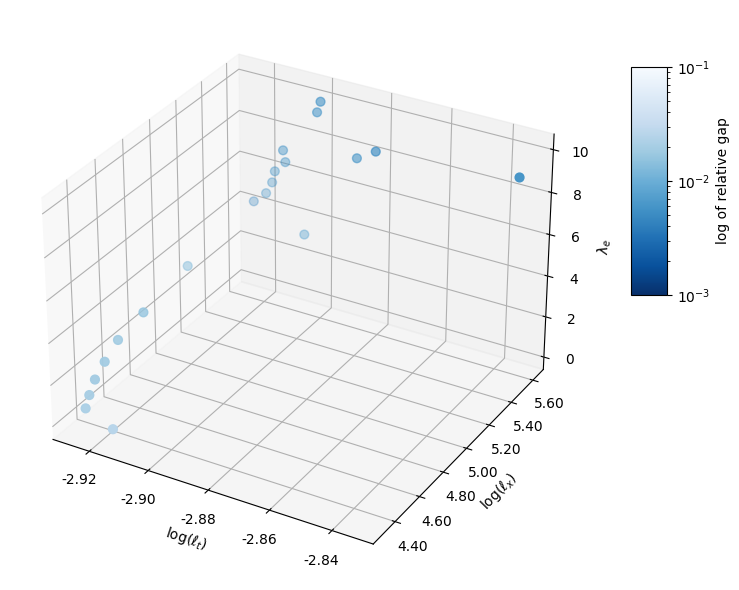

In [86]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (12,6))

x = np.log10(hyperparameter_search_eq['loss_tt'])
y = np.log10(hyperparameter_search_eq['loss_flow'])
z = hyperparameter_search_eq['lambdas_eq']
# x = hyperparameter_search_eq['loss_tt']
# y = hyperparameter_search_eq['loss_flow']
# z = hyperparameter_search_eq['lambdas_eq']

p = ax.scatter(x,y,z,
               c =hyperparameter_search_eq['relative_gaps'],
               # c =np.log10(hyperparameter_search_eq['loss_eq']),
               norm=colors.LogNorm(vmin=1e-3, vmax=1e-1),
               s=40, cmap='Blues_r')
cbar = plt.colorbar(p,
                    #ticks=[1e-3,1e-4,1e-5,1e-6,1e-7],
                    #ticks=np.linspace(start = 1e-6, stop = 1e-7,num = 5),
                    cax = fig.add_axes([0.78, 0.5, 0.03, 0.38]))
# cbar.set_label('log of equilibrium loss')
# cbar.set_label('log of relative gap')
# ax.set_xlabel('log of loss tt')
# ax.set_ylabel('log of loss flow')
# ax.set_zlabel('lambda eq')
cbar.set_label('log of relative gap')
ax.set_xlabel(r'$\log(\ell_t)$')
ax.set_ylabel(r'$\log(\ell_x)$')
ax.set_zlabel(r'$\lambda_{e}$')

#ax.xaxis._set_scale('log')
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.1e'))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax.margins(z=0)
#ax.view_init(40, 20)
#ax.zaxis._axinfo['label']['space_factor'] = 3.0
plt.tight_layout()

plt.show()

# view_1 = (25, -135)
# view_2 = (25, -45)
# init_view = view_2
# ax.view_init(*init_view)

In [37]:
hyperparameter_search_tt = pd.read_csv(f"./output/tables/{ts}_sensitivity_tt_{'Fresno'}.csv")

/var/folders/mg/t5yt0b_d1cg4ykytg0c22xcc0000gn/T/ipykernel_3188/192428184.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


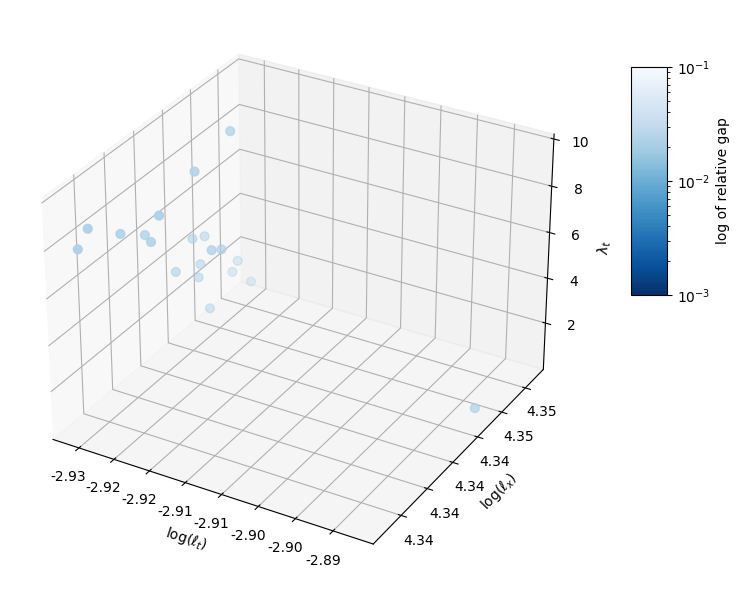

In [85]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 6))

x = np.log10(hyperparameter_search_tt['loss_tt'])
y = np.log10(hyperparameter_search_tt['loss_flow'])
z = hyperparameter_search_tt['lambda_tt']
# x = hyperparameter_search_eq['loss_tt']
# y = hyperparameter_search_eq['loss_flow']
# z = hyperparameter_search_eq['lambdas_tt']

p = ax.scatter(x,y,z,
               # c=np.log10(hyperparameter_search_tt['loss_eq']),
               #c=np.log10(hyperparameter_search_tt['relative_gaps']),
               c=hyperparameter_search_tt['relative_gaps'],
               norm=colors.LogNorm(vmin=1e-3, vmax=1e-1),
               s=40,
               cmap='Blues_r')
cbar = plt.colorbar(p,
                    #ticks=[1e-3,1e-4,1e-5,1e-6,1e-7],
                    #ticks=np.linspace(start = 1e-6, stop = 1e-7,num = 5),
                    cax=fig.add_axes([0.78, 0.5, 0.03, 0.38]))
#cbar.set_label('log of equilibrium loss')
cbar.set_label('log of relative gap')
ax.set_xlabel(r'$\log(\ell_t)$')
ax.set_ylabel(r'$\log(\ell_x)$')
ax.set_zlabel(r'$\lambda_{t}$')

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.margins(z=0)

plt.tight_layout()

plt.show()